In [2]:
import numpy as np
import pandas as pd
import pickle
import re

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan

In [3]:
pd.options.display.max_columns = None

In [5]:
train.shape # 展示原始数据

(570095, 2)

In [6]:
# 载入训练数据
test=pd.read_csv('test.csv')

In [7]:
test.shape

(157852, 2)

## 展示原始数据 

In [19]:
def show_state(state_str,n=1): # 每种状态打印几次
    count=0
    for i in train['message']:
        if state_str in i:
            print (i)
            count+=1
        if count>n:
            break

In [20]:
state_list=['Quote Start','Quote Incomplete','Quote Completed','Payment Completed','Claim Start','Claim Denied','Claim Accepted']
for s in state_list:
    print (s)
    show_state(s,0)   
    print ('\n')

Quote Start
7a9b9c479a2840f - pc_browser - Quote Started for customer: 112b2c


Quote Incomplete
fe668ffdb383461 - mobile_app - Quote Incomplete for customer: 496138 with json payload {'gender': 'female', 'name': 'Janet Colon', 'age': 46, 'address': '66 East Alex, Hicks Extensions Apt. ', 'email': 'Janet Colon@merritt.com', 'home': {'square_footage': 195.82090861888204, 'number_of_floors': 1, 'type': 0, 'number_of_bedrooms': 4}}


Quote Completed
c285423ba1474db - pc_browser - Quote Completed for customer: 112b2c with json payload {'gender': 'male', 'name': 'Tara Mcdonald', 'household': [{'age': 39, 'name': 'Kristen Mcdonald', 'gender': 'female'}], 'age': 41, 'address': '13 Frederickborough, Trevor Fort', 'email': 'Tara Mcdonald@smith.com', 'home': {'square_footage': 268.02897031547616, 'number_of_floors': 1, 'type': 1, 'number_of_bedrooms': 1}}


Payment Completed
8b63a9fd26ce44c - pc_browser - Payment Completed for customer: 97f991


Claim Start
2f1be42637dd491 - pc_browser - Claim S

提取id

In [21]:
train['id']=train['message'].apply(lambda x: x.split('customer: ')[1].split(' ')[0])

In [22]:
train.head()

,message,timestamp,id
0,7a9b9c479a2840f - pc_browser - Quote Started f...,1.388508e+09,112b2c
1,c285423ba1474db - pc_browser - Quote Completed...,1.388508e+09,112b2c
2,bdb9af7941b6493 - mobile_app - Quote Started f...,1.388515e+09,aafecc
3,932b6d1092b6440 - pc_browser - Quote Started f...,1.388516e+09,97f991
4,0bc89716a1754bb - mobile_app - Quote Completed...,1.388516e+09,aafecc


## 重组数据框:以id为聚合索引提取特征

In [23]:
data=dict(list(train.groupby('id')))

In [24]:
# message=data.get('496138')['message']
def browser(x):   
    return  x.split('-')[1].strip()
def personal_info(x):
    y=x.split('payload')[1]
    dict_y=eval(y)
    return dict_y

def feature_extract(feature):
    #### 基本信息 - 返回值为一个数
    #feature=[ 'gender','age','address','email']
    if feature in [ 'gender','age','address','email']:
        return dict_person[feature]
    
    #### 房屋信息
    if feature in ['square_footage','number_of_floors','type','number_of_bedrooms']:
        try: # 房屋里的信息是不完整的，有的房屋信息缺少某些特征
            return dict_person.get('home')[feature]
        except KeyError:
            return None

#### 家庭成员信息
    if feature in ['family_age','family_gender']:
        house_list=dict_person.get('household',None)
        if house_list:
            if feature =='family_age':
                age_list=[]
                for member in house_list:
                    age_list.append(member['age'])
                return age_list

            if feature =='family_gender':
                gender_list=[]
                for member in house_list:
                    gender_list.append(member['gender'])
                return gender_list
        else:
            return None

In [25]:
#### 初始化
feature_list=['gender','age','address','email',
                        'square_footage','number_of_floors','type','number_of_bedrooms',
                        'family_age','family_gender']
new_data={}
new_data['id']=[]
new_data['browser']=[]
for feature in feature_list:
    new_data[feature]=[]


###### 遍历所有id
for i in data.keys():
    new_data['id'].append(i)
    # 得到每个id的数据框
    message=data.get(i)['message']
    new_data['browser'].append(np.unique(message.apply(browser).values))
    # 提取特征
    try : # 检查dict_person是否存在
        for mm in message.values:
            if 'payload' in mm :
                dict_person=personal_info(mm)
                break # 家庭信息，若有则返回列表，没有则返回空列

        for feature in feature_list:
            new_data[feature].append(feature_extract(feature))
    except :  # 可能有的人没有提供过信息而只是看一看
        for feature in feature_list:
            new_data[feature].append(None)

In [26]:
for i in new_data.keys():
    print ('%s的长度是:%d'%(i,len(new_data[i])))

id的长度是:102497
browser的长度是:102497
gender的长度是:102497
age的长度是:102497
address的长度是:102497
email的长度是:102497
square_footage的长度是:102497
number_of_floors的长度是:102497
type的长度是:102497
number_of_bedrooms的长度是:102497
family_age的长度是:102497
family_gender的长度是:102497


In [54]:
# time_list=['Quote Started','Quote Incomplete','Quote Completed','Payment Completed','Claim Start','Claim Denied','Claim Accepted']
time_data={}
time_data['id']=[]
time_data['Quote_Started']=[]
time_data['Quote_Incomplete']=[]
time_data['Quote_Completed']=[]
time_data['Payment_Completed']=[]
time_data['Claim_Start']=[]
# time_data['Claim_Denied']=[]
# time_data['Claim_Accepted']=[]

time_data['Denied_Reason']=[]
time_data['Paid_amount']=[]
for i in data.keys():
    time_data['id'].append(i)
    # 得到每个id的数据框
    message=data.get(i)['message'].values
    timestamp=data.get(i)['timestamp'].values
    
    t1=[]
    t2=[]
    t3=[]
    t4=[]
    t5=[]
#     t6=[]
#     t7=[]
    r=[]
    p=[]
    for j in range(len(message)):# 对每个id下的表格的message的每一行进行提取时间信息
        m=message[j]
        t=timestamp[j]
        
        if 'Quote Started' in m:
            t1.append(t)
            
        if 'Quote Incomplete' in m:
            t2.append(t)
            
        if 'Quote Completed' in m:
            t3.append(t)
            
        if 'Payment Completed' in m:
            t4.append(t)
            
        if 'Claim Start' in m:
            t5.append(t)
            
        if 'Claim Denied' in m:
#             t6.append(t)
            r.append(m.split('reason : ')[1].strip())
            
        if 'Claim Accepted' in m:
#             t7.append(t)
            p.append(m.split('$')[1].strip())
    time_data['Quote_Started'].append(t1)
    time_data['Quote_Incomplete'].append(t2)
    time_data['Quote_Completed'].append(t3)
    time_data['Payment_Completed'].append(t4)
    time_data['Claim_Start'].append(t5)
#     time_data['Claim_Denied'].append(t6)
#     time_data['Claim_Accepted'].append(t7)

    time_data['Denied_Reason'].append(r)
    time_data['Paid_amount'].append(p)

In [55]:
df_train=pd.merge(pd.DataFrame(new_data),pd.DataFrame(time_data),on='id')

In [56]:
df_train.head() # 展示几行新数据框

,id,browser,gender,age,address,email,square_footage,number_of_floors,type,number_of_bedrooms,family_age,family_gender,Quote_Started,Quote_Incomplete,Quote_Completed,Payment_Completed,Claim_Start,Denied_Reason,Paid_amount
0,000164,[pc_browser],female,26,"112 North Lisastad, Billy Squares",Sara Harris DDS@brown.biz,249.451933,1.0,0,2.0,[26],[female],[1400235317.9621642],[],[1400235980.733095],[1400236091.3723712],"[1403803934.639876, 1406116920.057272, 1406782...",[],"[4946.49, 4946.49, 4946.49, 4946.49, 4946.49, ..."
1,0001bc,[pc_browser],female,56,"21 Ericachester, Glover Mountains",Dana Wade@yahoo.com,293.366810,1.0,1,3.0,None,None,[1450860139.229834],[],[1450860872.898955],[],[],[],[]
2,00020c,[pc_browser],male,61,"125 Bondchester, Kimberly Landing",Virginia Rice@padilla.org,336.573503,1.0,1,3.0,"[61, 21, 17]","[female, male, female]",[1477411711.7405028],[],[1477412093.002691],[1477412251.96969],[],[],[]
3,000438,[mobile_browser],female,48,"119 Lydiaside, Jimmy Cliff Apt.",Linda Morris@knox.com,286.749852,1.0,1,3.0,"[48, 44]","[female, female]",[1407395080.889485],[],[1407395537.097718],[1407395641.378007],"[1407662426.222398, 1419887530.787627]",[],"[6372.6, 6372.6]"
4,000489,[pc_browser],male,55,"21 Bondchester, Carmen Way",Jackson Wilson PhD@rodriguez-allen.com,436.600452,1.0,1,2.0,"[55, 7, 15]","[male, male, male]",[1409191532.95371],[],[1409191538.875976],[],[],[],[]


In [30]:
df_train.shape # 确认数据框形状

(102497, 21)

保存数据框为pkl格式

In [57]:
# f = open('train_new', 'wb')
# pickle.dump(df_train, f)
# f.close()

In [8]:
# Restore from a file
f = open('train_new', 'rb')
df_train = pickle.load(f)

f.close()

In [6]:
df_train.isnull().sum()

id                        0
browser                   0
gender                    0
age                       0
address                   0
email                     0
square_footage         9068
number_of_floors       9068
type                      0
number_of_bedrooms     9068
family_age            26475
family_gender         26475
Quote_Started             0
Quote_Incomplete          0
Quote_Completed           0
Payment_Completed         0
Claim_Start               0
Denied_Reason             0
Paid_amount               0
dtype: int64

In [138]:
# data['0628cc']['message'].iloc[1]

In [41]:
# df_train[df_train['id']=='0010d9']

##  在重组数据框上进一步组合特征

In [10]:
df_train.head(3)

,id,browser,gender,age,address,email,square_footage,number_of_floors,type,number_of_bedrooms,family_age,family_gender,Quote_Started,Quote_Incomplete,Quote_Completed,Payment_Completed,Claim_Start,Denied_Reason,Paid_amount
0,000164,[pc_browser],female,26,"112 North Lisastad, Billy Squares",Sara Harris DDS@brown.biz,249.451933,1.0,0,2.0,[26],[female],[1400235317.9621642],[],[1400235980.733095],[1400236091.3723712],"[1403803934.639876, 1406116920.057272, 1406782...",[],"[4946.49, 4946.49, 4946.49, 4946.49, 4946.49, ..."
1,0001bc,[pc_browser],female,56,"21 Ericachester, Glover Mountains",Dana Wade@yahoo.com,293.366810,1.0,1,3.0,None,None,[1450860139.229834],[],[1450860872.898955],[],[],[],[]
2,00020c,[pc_browser],male,61,"125 Bondchester, Kimberly Landing",Virginia Rice@padilla.org,336.573503,1.0,1,3.0,"[61, 21, 17]","[female, male, female]",[1477411711.7405028],[],[1477412093.002691],[1477412251.96969],[],[],[]


In [120]:
# df_train.apply(lambda x :x.iloc[1])

### 家庭信息特征 

**澳大利亚年龄划分**  
https://www.abs.gov.au/ausstats/abs@.nsf/0/1CD2B1952AFC5E7ACA257298000F2E76?OpenDocument   
- CHILDREN (AGED 0-14 YEARS)
- WORKING-AGE POPULATION (AGED 15-64 YEARS)
- PEOPLE AGED 65 YEARS AND OVER


In [11]:
def age_count(x):
    if x:
        count1=0
        count2=0
        count3=0
        for i in x:
            if i <=14:
                count1+=1
            elif i<=64:
                count2+=1
            else:
                count3+=1
        return count1,count2,count3
    else:
        return None
        

In [12]:
age_class=df_train['family_age'].apply(age_count)
df_train['nf_children']=age_class.apply(lambda x: x[0] if x else 0)
df_train['nf_working']=age_class.apply(lambda x: x[1] if x else 0)
df_train['nf_old']=age_class.apply(lambda x: x[2] if x else 0)

In [13]:
df_train['Fraud']=df_train.Denied_Reason.apply(lambda x: 1 if x else 0) # 增加Fraud的0-1变量，标识欺诈与非欺诈
df_train['Paid_amount']=df_train['Paid_amount'].apply(lambda x:np.mean(list(map(float,x))) if x else 0)
df_train.email=df_train.email.apply(lambda x: x.split('@')[1])


In [14]:
df_train['nfamily']=df_train['family_age'].apply(lambda x: len(x) if x else 0) # 增加有无家人的变量
df_train['nfamily_female']=df_train['family_gender'].apply(lambda x :Counter(x)['female'])
df_train['nfamily_male']=df_train['family_gender'].apply(lambda x:Counter(x)['male'])

In [15]:
age_class=df_train['family_age'].apply(age_count)
df_train['nf_children']=age_class.apply(lambda x: x[0] if x else None)
df_train['nf_working']=age_class.apply(lambda x: x[1] if x else None)
df_train['nf_old']=age_class.apply(lambda x: x[2] if x else None)

In [16]:
df_train['family_age_mean']=df_train['family_age'].apply(lambda x: np.mean(x) if x else None)
df_train['family_age_max']=df_train['family_age'].apply(lambda x: np.max(x) if x else None)
df_train['family_age_min']=df_train['family_age'].apply(lambda x: np.min(x) if x else None)
df_train['family_age_range']=df_train['family_age_max']-df_train['family_age_min']
df_train['family_age_std']=df_train['family_age'].apply(lambda x: np.std(x) if x else None)

In [17]:
df_train.Fraud.value_counts() # 欺诈与非欺诈，样本不平衡问题

0    100783
1      1714
Name: Fraud, dtype: int64

In [36]:
df_train.shape

(102497, 36)

In [46]:
np.median(df_train[df_train.Paid_amount!=0]['Paid_amount'])

6676.885

In [44]:
df_train[df_train.Paid_amount==20912.89]

,id,browser,gender,age,address,email,square_footage,type,number_of_bedrooms,family_age,family_gender,Quote_Started,Quote_Incomplete,Quote_Completed,Payment_Completed,Claim_Start,Denied_Reason,Paid_amount,nf_children,nf_working,nf_old,Fraud,nfamily,nfamily_female,nfamily_male,family_age_mean,family_age_max,family_age_min,family_age_range,family_age_std,mobile_browser,pc_browser,mobile_app,phone_call,t4,claim_or_not
19531,30e463,[pc_browser],female,71,"109 Anthonytown, Snyder Gardens Apt.",gmail.com,492.685172,1,3.0,"[73, 76, 70, 65, 69, 12, 9]","[female, female, female, male, male, male, fem...",[1454220000.0],[],[1454220232.105372],[1454220370.83799],[1454220370.83799],[],20912.89,2.0,0.0,5.0,0,7,4,3,53.428571,76.0,9.0,67.0,27.343618,0,1,0,0,0.0,1


In [64]:
df_train.number_of_floors.value_counts()# number_of_bedrooms处理成类别变量，number of floors可以删除

1.0    93428
2.0        1
Name: number_of_floors, dtype: int64

In [18]:
del df_train['number_of_floors']

In [14]:
df_train[df_train.browser.apply(len)==3].head(2)

,id,browser,gender,age,address,email,square_footage,type,number_of_bedrooms,family_age,family_gender,Quote_Started,Quote_Incomplete,Quote_Completed,Payment_Completed,Claim_Start,Denied_Reason,Paid_amount,nf_children,nf_working,nf_old,Fraud,nfamily,nfamily_female,nfamily_male,family_age_mean,family_age_max,family_age_min,family_age_range,family_age_std
66747,a6d1bc,"[mobile_app, mobile_browser, pc_browser]",male,45,"52 South Ruben, Eric Path",mitchell-peterson.com,NaN,1,NaN,"[53, 33, 42, 45]","[male, male, female, female]","[1391800215.789767, 1461068695.4217901, 147175...",[1391800457.583778],"[1461069600.4495962, 1471756228.086967]",[1461069676.992136],[1464969807.283076],[],11762.36,0.0,4.0,0.0,0,4,2,2,43.25,53.0,33.0,20.0,7.154544


In [19]:
## 提取浏览器特征
df_train['mobile_browser']=df_train['browser'].apply(lambda x:Counter(x)['mobile_browser'])
df_train['pc_browser']=df_train['browser'].apply(lambda x:Counter(x)['pc_browser'])
df_train['mobile_app']=df_train['browser'].apply(lambda x:Counter(x)['mobile_app'])
df_train['phone_call']=df_train['browser'].apply(lambda x:Counter(x)['phone_call'])

### 时间戳特征 

In [300]:
# df_train[df_train['t4']==0]

In [301]:
# df_train[df_train.browser.apply(len)!=1].head(2)

In [20]:
# Quote_Completed-Quote_Started
# df_train['t1']=df_train.apply(lambda x:sorted(x['Quote_Completed'])[0]-sorted(x['Quote_Started'])[0] 
#                               if x['Quote_Completed'] else None,axis=1)

# #  Quote_Incomplete-Quote_Started
# df_train['t2']=df_train.apply(lambda x:sorted(x['Quote_Incomplete'])[0]-sorted(x['Quote_Started'])[0] 
#                               if x['Quote_Incomplete'] else None,axis=1)

# # Payment_Completed-Quote_Completed
# df_train['t3']=df_train.apply(lambda x:x['Payment_Completed'][0]-sorted(x['Quote_Completed'])[0] 
#                               if x['Quote_Completed'] and x['Payment_Completed'] else None,axis=1)

# Claim_Start-Payment_Completed
df_train['t4']=df_train.apply(lambda x:sorted(x['Claim_Start'])[0]-x['Payment_Completed'][0]
                              if x['Claim_Start'] and x['Payment_Completed'] else None,axis=1)

In [318]:
# df_train['pay_or_not']=df_train['Payment_Completed'].apply(lambda x:1 if x else 0)

In [21]:
df_train['claim_or_not']=df_train['Claim_Start'].apply(lambda x:1 if x else 0)

In [21]:
pd.crosstab(df_train.claim_or_not, df_train.Paid_amount.apply(lambda  x :1 if x else 0))

Paid_amount,0,1
claim_or_not,,
0,74925,0
1,1710,25862


##  EDA

In [102]:
selected_columns=['Paid_amount', 'gender', 'age',  'square_footage',
       'type', 'number_of_bedrooms',
       'nf_children', 'nf_working', 'nfamily',
       'nfamily_male',  'family_age_mean', 
       'family_age_min', 'family_age_range', 'family_age_std',
       ]
train_df=df_train[selected_columns]

train_df=train_df[train_df['Paid_amount']!=0]

# train_df=train_df[train_df['t4']!=0]

In [110]:
train_df.head()

,Paid_amount,gender,age,square_footage,type,number_of_bedrooms,nf_children,nf_working,nfamily,nfamily_male,family_age_mean,family_age_min,family_age_range,family_age_std,rate_children,rate_working
0,4946.49,female,26,249.451933,0,2.0,0.0,1.0,1,0,26.0,26.0,0.0,0.0,0.0,1.0
3,6372.60,female,48,286.749852,1,3.0,0.0,2.0,2,0,46.0,44.0,4.0,2.0,0.0,1.0
6,8214.35,female,37,358.658040,1,2.0,0.0,1.0,1,0,39.0,39.0,0.0,0.0,0.0,1.0
8,6112.79,female,57,301.360136,1,4.0,1.0,1.0,2,1,13.5,9.0,9.0,4.5,0.5,0.5
19,7106.54,male,64,332.433413,1,3.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
train_df['rate_children']=train_df['nf_children']/train_df['nfamily']
train_df['rate_working']=train_df['nf_working']/train_df['nfamily']

train_df['rate_male']=train_df['nfamily_male']/train_df['nfamily']

In [53]:
train_df.shape

(25862, 14)

###  时间戳与机器人

C:\Users\wufan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\wufan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


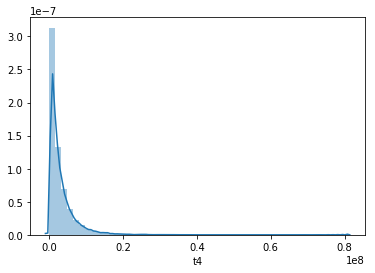

In [26]:
sns.distplot(df_train['t4'].dropna())

### 浏览器与欺诈

In [302]:
Counter(df_train.browser.apply(len))

Counter({1: 102241, 2: 255, 3: 1})

In [162]:
sub_browser=df_train[['browser','Fraud']]

bro=sub_browser.browser.values
fra=sub_browser.Fraud.values

Bro=[]
Fra=[]
for i in range(len(bro)):
    if len(bro[i])==1:
        Bro.append(bro[i][0])
        Fra.append(fra[i])
    else:
        for j in bro[i]:
            Bro.append(j)
            Fra.append(fra[i])

sub_b_f=pd.DataFrame({'browser':Bro,'fraud':Fra})

In [306]:
ct = pd.crosstab(sub_b_f.browser, sub_b_f.fraud)
ct
# ct.plot.bar(stacked=True)
# plt.legend(title='mark')

# plt.show()


fraud,0,1
browser,,
mobile_app,20037,353
mobile_browser,29801,552
pc_browser,41188,821
phone_call,10001,1


Text(0.5,1,'无欺诈用户浏览器分布图')

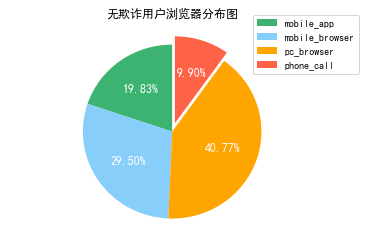

In [307]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(4,4))
plt.pie(ct[0],
        labels=ct.index,  
   colors=('mediumseagreen', 'lightskyblue', 'orange', 'tomato'),  
    autopct='%1.2f%%'  ,
#        pctdistance=0.8,
        shadow=False,
    labeldistance=1.1,   
    counterclock=True, 
        startangle=90,
    center = (0, 0),
        explode = [0,0,0,0.1],
        textprops={'fontsize': 12, 'color': 'w'},
#         shadow=False
       ) 
plt.legend(loc='center',bbox_to_anchor=(1.1,0.9))
plt.title('无欺诈用户浏览器分布图')

Text(0.5,1,'欺诈用户浏览器分布图')

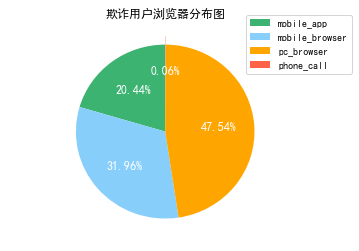

In [308]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(4,4))
plt.pie(ct[1],
        labels=ct.index,  
   colors=('mediumseagreen', 'lightskyblue', 'orange', 'tomato'),  
    autopct='%1.2f%%'  ,
#        pctdistance=0.8,
        shadow=False,
    labeldistance=1.1,   
    counterclock=True, 
        startangle=90,
    center = (0, 0),
        explode = [0,0,0,0.1],
        textprops={'fontsize': 12, 'color': 'w'},
#         shadow=False
       ) 
plt.legend(loc='center',bbox_to_anchor=(1.1,0.9))
plt.title('欺诈用户浏览器分布图')

### 房型和金额

In [124]:
train_df.type.value_counts() # type处理成0-1变量,房屋类型都是有的，只是有的房子没有bedroom等信息

1    17294
0     8233
Name: type, dtype: int64

### 赔付金额分布

C:\Users\wufan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\wufan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


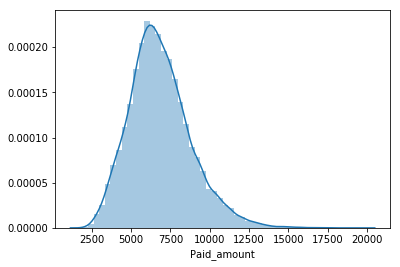

In [154]:
sns.distplot(train_df['Paid_amount'])

###  性别与赔付金额

Text(0.5,0,'性别')

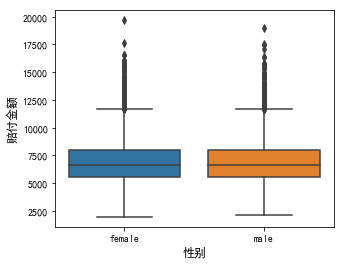

In [161]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('gender','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('性别',fontsize=12.0)

### 房型与赔付金额

Text(0.5,0,'房型')

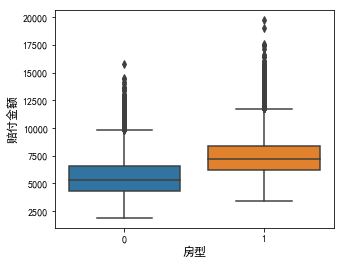

In [183]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('type','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('房型',fontsize=12.0)

###  人口指标与赔付金额

Text(0.5,0,'孩子数')

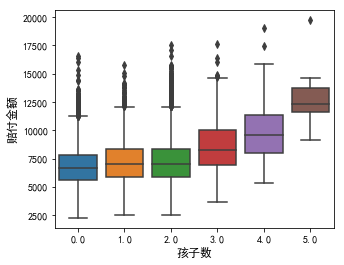

In [184]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nf_children','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('孩子数',fontsize=12.0)

Text(0.5,0,'工作人口数')

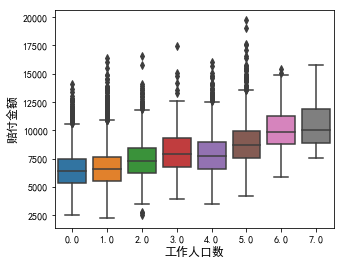

In [185]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nf_working','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('工作人口数',fontsize=12.0)

Text(0.5,0,'老人数')

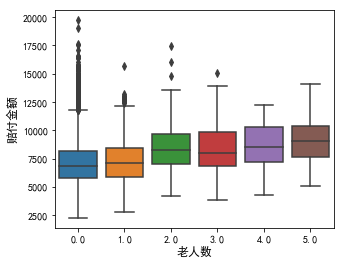

In [186]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nf_old','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('老人数',fontsize=12.0)

Text(0.5,0,'家人总数')

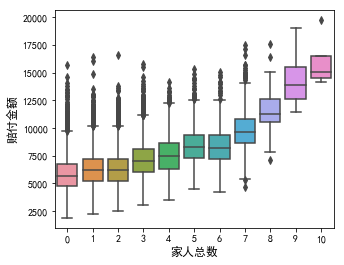

In [187]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nfamily','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('家人总数',fontsize=12.0)

Text(0.5,0,'家中女人数')

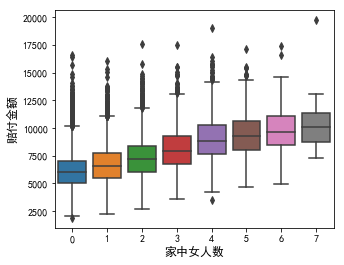

In [188]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nfamily_female','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('家中女人数',fontsize=12.0)

Text(0.5,0,'家中男人数')

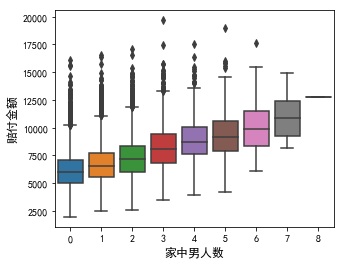

In [189]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('nfamily_male','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('家中男人数',fontsize=12.0)

### 浏览器与赔付金额

Text(0.5,0,'性别')

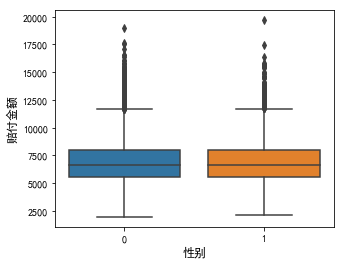

In [174]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('pc_browser','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('性别',fontsize=12.0)

Text(0.5,0,'性别')

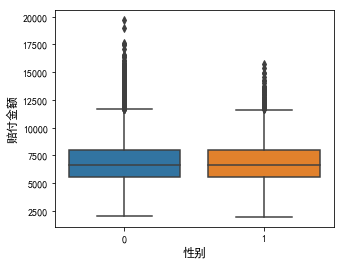

In [175]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('mobile_app','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('性别',fontsize=12.0)

Text(0.5,0,'性别')

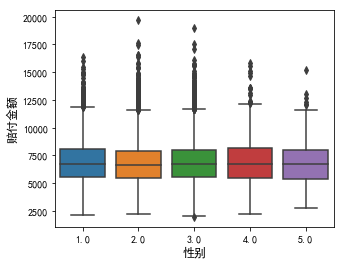

In [192]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(5,4))
sns.boxplot('phone_call','Paid_amount',data=train_df)
plt.ylabel('赔付金额',fontsize=12.0)
plt.xlabel('性别',fontsize=12.0)

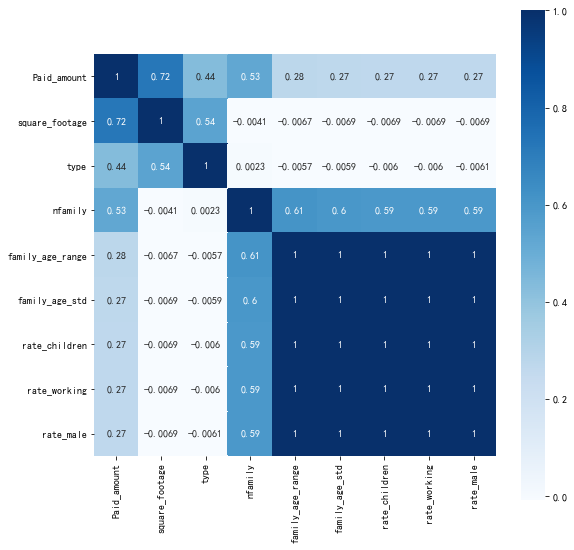

In [167]:
dfData = train_df.corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
plt.savefig('heatmap.png')
# sns.heatmap(dfData)

Text(0,0.5,'赔偿金额')

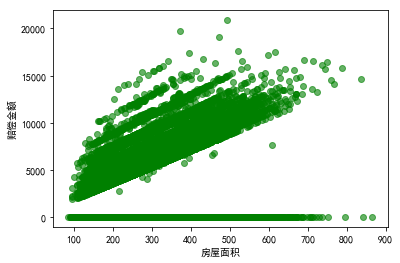

In [169]:
plt.rcParams['font.family'] = 'SimHei'
plt.scatter(df_train.square_footage,df_train.Paid_amount,alpha=0.6,color='g')
plt.xlabel('房屋面积')
plt.ylabel('赔偿金额')

## 建模

经过以上处理，实际建模过程变成：  
- 将样本中t4=0的用户定价为0（可能为欺诈的机器人）
- 对剩下的用户进行回归建模

In [112]:
train_df.drop(['gender','nf_working',
              'age','number_of_bedrooms','nf_children',
               'family_age_mean','family_age_min','nfamily_male'],inplace=True,axis=1)

删除：age,number of bedrooms,n_childre,n_old,family_age_mean

In [120]:
train_df.head()

,Paid_amount,square_footage,type,nfamily,family_age_range,family_age_std,rate_children,rate_working,rate_male
0,4946.49,249.451933,0,1,0.0,0.0,0.0,1.0,0.0
3,6372.60,286.749852,1,2,4.0,2.0,0.0,1.0,0.0
6,8214.35,358.658040,1,1,0.0,0.0,0.0,1.0,0.0
8,6112.79,301.360136,1,2,9.0,4.5,0.5,0.5,0.5
19,7106.54,332.433413,1,0,-999.0,-999.0,-999.0,-999.0,-999.0


In [156]:
df_train[df_train['Fraud']!=1].shape

(100783, 36)

In [166]:
 a=df_train[df_train['Fraud']==1]
a[df_train.Paid_amount!=0]['id'].values

C:\Users\wufan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array(['1cf225', 'ba87a0', 'c9fb57', 'cf3686'], dtype=object)

In [119]:
train_df.fillna(-999,inplace=True)

# train_df['nf_working']=train_df['nf_working'].apply(lambda x: int(x) if not isnan(x) else None)

In [121]:
train_df.dtypes

Paid_amount         float64
square_footage      float64
type                  int64
nfamily               int64
family_age_range    float64
family_age_std      float64
rate_children       float64
rate_working        float64
rate_male           float64
dtype: object

In [122]:
X = train_df.drop(['Paid_amount'], axis=1)
y = train_df.Paid_amount

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)

In [123]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

#importing library and building model
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=50, depth=7, learning_rate=0.15, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6161.0113248	test: 6166.8688057	best: 6166.8688057 (0)	total: 15.3ms	remaining: 752ms
1:	learn: 5289.3449002	test: 5293.5830608	best: 5293.5830608 (1)	total: 51.4ms	remaining: 1.23s
2:	learn: 4553.2276472	test: 4560.0312442	best: 4560.0312442 (2)	total: 79.9ms	remaining: 1.25s
3:	learn: 3930.2565630	test: 3937.9422605	best: 3937.9422605 (3)	total: 113ms	remaining: 1.3s
4:	learn: 3396.9699830	test: 3404.6632651	best: 3404.6632651 (4)	total: 138ms	remaining: 1.24s
5:	learn: 2946.8684492	test: 2956.0889702	best: 2956.0889702 (5)	total: 174ms	remaining: 1.28s
6:	learn: 2570.4735668	test: 2579.0951038	best: 2579.0951038 (6)	total: 212ms	remaining: 1.3s
7:	learn: 2255.6722705	test: 2266.7113512	best: 2266.7113512 (7)	total: 250ms	remaining: 1.31s
8:	learn: 1992.8588748	test: 2004.8032415	best: 2004.8032415 (8)	total: 300ms	remaining: 1.37s
9:	learn: 1769.9168112	test: 1780.9568399	best: 1780.9568399 (9)	total: 330ms	remaining: 1.32s
10:	learn: 1586.0899681	test: 1594.7938485	best: 

In [124]:
model.feature_importances_

array([53.33622237,  8.98734975,  5.46785648, 11.38703018,  5.21663061,
        6.81409674,  4.70192665,  4.08888724])

In [125]:
model.feature_names_

['square_footage',
 'type',
 'nfamily',
 'family_age_range',
 'family_age_std',
 'rate_children',
 'rate_working',
 'rate_male']

In [136]:
rect.get_width()

53.33622236758611

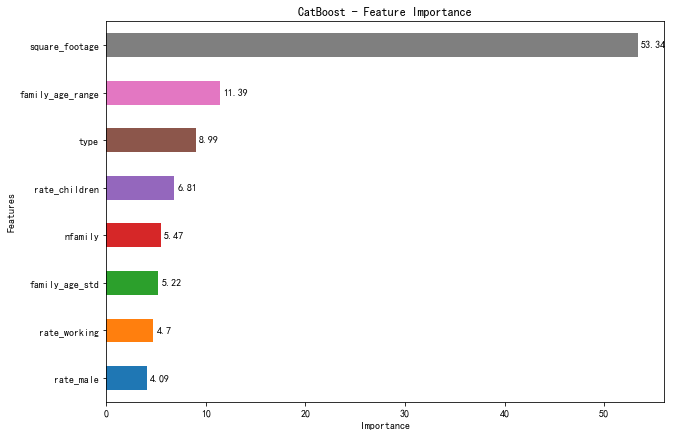

In [150]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': model.feature_names_})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
ax=fea_imp.plot(kind='barh', x='col', y='imp', label='imp',figsize=(10, 7), legend=None)

rects = ax.patches

labels = fea_imp['imp'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_width()+0.35 , rect.get_y()+0.2 , label)

plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.savefig('Feature_Importance')

In [151]:
from sklearn.metrics import r2_score
y_true=y_validation
y_pred=model.predict(X_validation)
print(r2_score(y_true,y_pred))

0.8818248662576869


In [125]:
# from sklearn.model_selection import GridSearchCV

# param_test = {
#         'depth': [4, 7, 10],
#           'learning_rate' : [0.03, 0.05, 0.15],
#          'l2_leaf_reg': [1,4,9],
#          'iterations': [50],
#     }
# catb=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1,l2_leaf_reg=2,loss_function='RMSE')
# gsearch = GridSearchCV( catb , param_grid = param_test, scoring='r2', cv=5 )
# gsearch.fit( X, y)

In [134]:
gsearch.best_params_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000001901885E358>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 7, 10], 'iterations': [300],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.05, 0.15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [90]:
catb=CatBoostRegressor(iterations=50, depth=7, learning_rate=0.15, loss_function='RMSE')

In [152]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(catb, X, y, cv=4))
# print(cross_cal_score(lr, X, y, cv=2))

0:	learn: 6138.7704040	total: 25.5ms	remaining: 1.25s
1:	learn: 5258.2113270	total: 50.1ms	remaining: 1.2s
2:	learn: 4510.0347371	total: 73.6ms	remaining: 1.15s
3:	learn: 3873.3872601	total: 95.8ms	remaining: 1.1s
4:	learn: 3337.7860733	total: 118ms	remaining: 1.06s
5:	learn: 2887.7345265	total: 140ms	remaining: 1.03s
6:	learn: 2505.5272105	total: 163ms	remaining: 999ms
7:	learn: 2187.0380687	total: 176ms	remaining: 927ms
8:	learn: 1915.9752784	total: 199ms	remaining: 907ms
9:	learn: 1689.8549928	total: 223ms	remaining: 892ms
10:	learn: 1495.3566424	total: 256ms	remaining: 908ms
11:	learn: 1337.4480442	total: 297ms	remaining: 941ms
12:	learn: 1209.6003669	total: 329ms	remaining: 936ms
13:	learn: 1100.4961803	total: 356ms	remaining: 917ms
14:	learn: 1015.8641381	total: 381ms	remaining: 890ms
15:	learn: 949.9419545	total: 410ms	remaining: 872ms
16:	learn: 894.1191171	total: 432ms	remaining: 838ms
17:	learn: 850.1928661	total: 457ms	remaining: 813ms
18:	learn: 815.3033159	total: 484ms	rem

8:	learn: 1910.0894850	total: 271ms	remaining: 1.24s
9:	learn: 1682.2551733	total: 311ms	remaining: 1.24s
10:	learn: 1491.2047693	total: 341ms	remaining: 1.21s
11:	learn: 1336.9641795	total: 367ms	remaining: 1.16s
12:	learn: 1208.7660970	total: 393ms	remaining: 1.12s
13:	learn: 1101.2871255	total: 417ms	remaining: 1.07s
14:	learn: 1014.5824349	total: 442ms	remaining: 1.03s
15:	learn: 947.9113946	total: 465ms	remaining: 989ms
16:	learn: 896.2284552	total: 501ms	remaining: 973ms
17:	learn: 854.5334586	total: 526ms	remaining: 936ms
18:	learn: 820.5476912	total: 551ms	remaining: 899ms
19:	learn: 794.9825090	total: 574ms	remaining: 862ms
20:	learn: 776.0543996	total: 591ms	remaining: 817ms
21:	learn: 759.2931036	total: 615ms	remaining: 783ms
22:	learn: 746.1663578	total: 638ms	remaining: 749ms
23:	learn: 734.7372755	total: 662ms	remaining: 717ms
24:	learn: 726.1704740	total: 686ms	remaining: 686ms
25:	learn: 718.3891063	total: 714ms	remaining: 659ms
26:	learn: 711.1550623	total: 738ms	remai

In [153]:
a=[683.86248773,694.47236701 ,681.31412739 ,694.90001257]
np.mean(a)

688.637248675

In [92]:
model_train=CatBoostRegressor(iterations=50, depth=7, learning_rate=0.15, loss_function='RMSE')
model_train.fit(X, y,cat_features=categorical_features_indices,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6136.6338733	total: 49.5ms	remaining: 2.43s
1:	learn: 5259.0186654	total: 82.6ms	remaining: 1.98s
2:	learn: 4515.3520488	total: 106ms	remaining: 1.65s
3:	learn: 3894.4329993	total: 129ms	remaining: 1.48s
4:	learn: 3373.5169443	total: 154ms	remaining: 1.39s
5:	learn: 2933.6111767	total: 188ms	remaining: 1.38s
6:	learn: 2561.9758401	total: 236ms	remaining: 1.45s
7:	learn: 2250.5861113	total: 283ms	remaining: 1.49s
8:	learn: 1993.9807489	total: 328ms	remaining: 1.49s
9:	learn: 1784.5575391	total: 360ms	remaining: 1.44s
10:	learn: 1614.0918678	total: 387ms	remaining: 1.37s
11:	learn: 1479.2029619	total: 408ms	remaining: 1.29s
12:	learn: 1373.1496693	total: 432ms	remaining: 1.23s
13:	learn: 1285.3267600	total: 469ms	remaining: 1.21s
14:	learn: 1218.0493683	total: 506ms	remaining: 1.18s
15:	learn: 1165.1458162	total: 541ms	remaining: 1.15s
16:	learn: 1076.1858972	total: 570ms	remaining: 1.1s
17:	learn: 1002.3341295	total: 593ms	remaining: 1.05s
18:	learn: 943.4339560	total: 618ms	r

In [175]:
from sklearn.externals import joblib
joblib.dump(model_train, "train_model.m")

['train_model.m']